In [1]:
%pylab inline
import os
os.environ['XLA_FLAGS'] = "--xla_force_host_platform_device_count=8"
import jax
import jax.numpy as np
import vbjax
import tqdm
from IPython import clear_output
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
** shtns is not available


## Set up the model

### Neural mass: Jansen-Rit

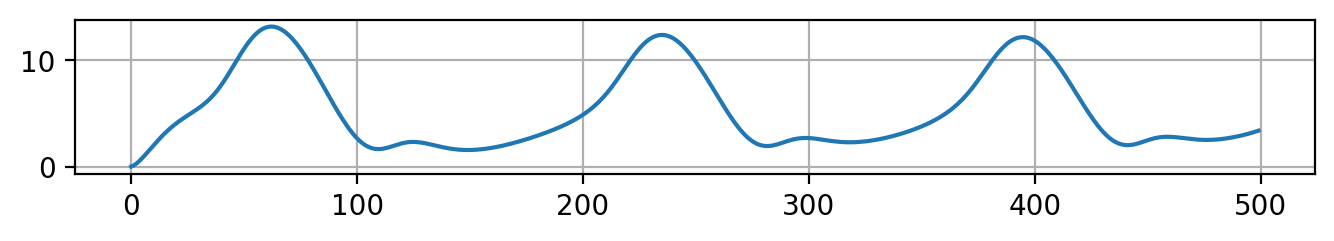

In [2]:
def make_curve():
    dt = 1
    ts = np.r_[:500]
    _, loop = vbjax.make_ode(dt, lambda x, p: vbjax.jr_dfun(x, 0, p))
    def curve(x0,p):
        xs = loop(x0, ts, p)
        v = xs[:, 1] - xs[:, 2]
        return np.clip(v,-60,60)  # avoid numerical problems
    return curve

curve = make_curve()
x0 = np.zeros(6)
p = vbjax.jr_default_theta
x = curve(x0, p)
figure(figsize=(8, 1)); plot(x); grid(1)

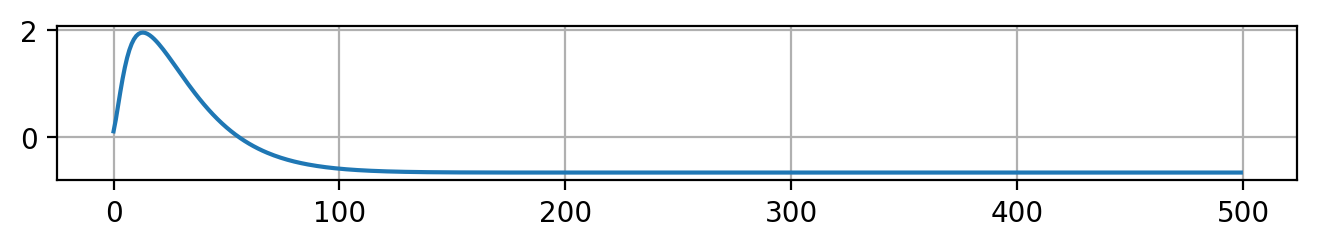

In [3]:
ph = vbjax.jr_default_theta._replace(a=0.3)
figure(figsize=(8, 1)); plot(curve(x0, ph)); grid(1)

### Connectome

There's a few collections, but we can start with the classic HCP 100

In [4]:
import glob, os
glob.glob(os.path.expanduser('~/EBRAINS/Seafile/Insference/connectomes/*.npz'))

['/Users/duke/EBRAINS/Seafile/Insference/connectomes/1kb-274.npz',
 '/Users/duke/EBRAINS/Seafile/Insference/connectomes/hcp-100.npz',
 '/Users/duke/EBRAINS/Seafile/Insference/connectomes/hcp-200.npz']

In [5]:
npz = np.load(os.path.expanduser('~/EBRAINS/Seafile/Insference/connectomes/hcp-100.npz'))
list(npz.keys())

['lengths', 'weights']

In [6]:
lengths = npz['lengths']
weights = npz['weights']
lengths.shape

(100, 84, 84)

In [7]:
vbjax.jr_dfun?

Signature: vbjax.jr_dfun(ys, c, p)
Docstring: <no docstring>
File:      ~/src/vbjax/vbjax/neural_mass.py
Type:      function

In [8]:
vbjax.make_linear_cfun?

Signature: vbjax.make_linear_cfun(SC, a=1.0, b=0.0)
Docstring:
Construct a linear coupling function with slope `a` and offset `b`.
    
File:      ~/src/vbjax/vbjax/coupling.py
Type:      function

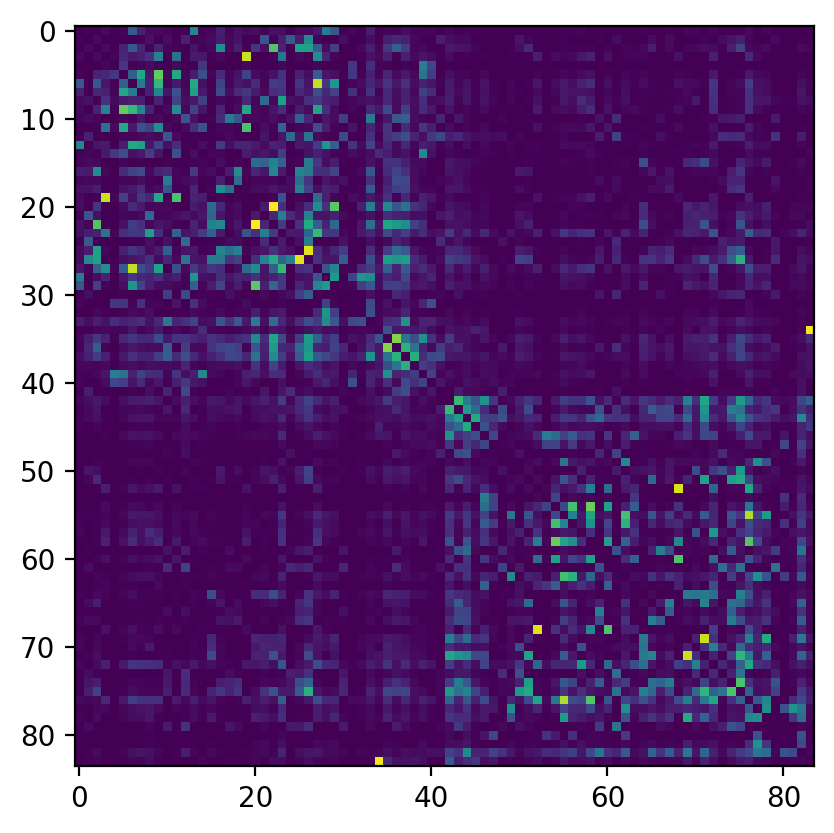

In [9]:
SC = np.array(weights[0])
SC = SC + SC.T
SC /= SC.max()
SC = np.sqrt(SC)  # Spase Qetkoski's Rational Trick
imshow(SC)

In [10]:
cf = vbjax.make_linear_cfun(SC)
def net_dfun(x, k_p):
    k, p = k_p
    return vbjax.jr_dfun(x, k*cf(x[1] - x[0]), p)

nn = SC.shape[0]
x = np.zeros((6, nn))

### SDE system

In [11]:
dt = 2.0
step, loop = vbjax.make_sde(dt, net_dfun, 0.0005)

key = jax.random.PRNGKey(42)
zs = jax.random.normal(key=key, shape=(500+8192, 6, nn))

### Example simulation

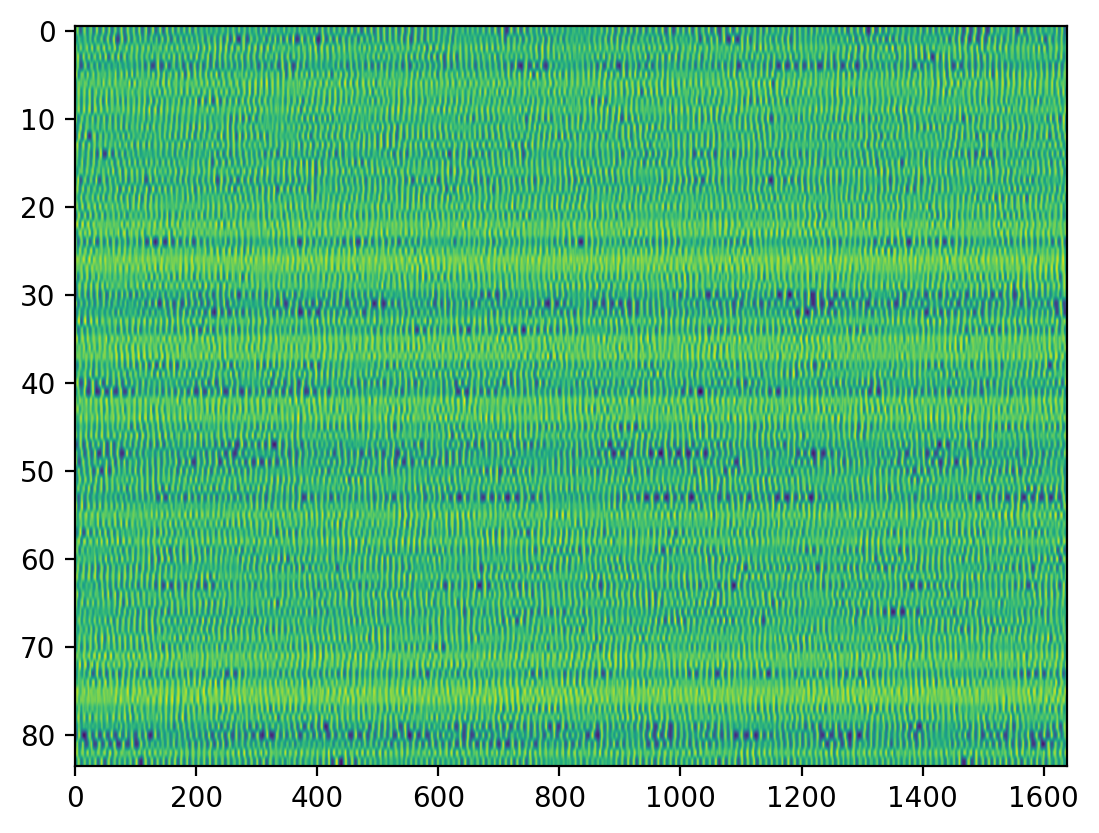

In [12]:
k_p = 1e-3, p
# %timeit loop(x, zs, k_p)
xs = loop(x, zs, k_p)
imshow(xs[-8192:][::5,0].T, aspect='auto');

## Design a data feature

### Univariate 

going for cross spectra as a data feature, let's first identify the spectrum in a single time series

In [13]:
lfp = xs[:,1]-xs[:,0]
X = np.fft.fft(lfp[-8192:,::10].reshape((-1,256,9))[2:], axis=1)
wcX = np.zeros((30, 256, 9, 9), np.complex64)
for i in range(9):
    for j in range(9):
        wcX.at[..., i, j].set(X[..., i] * X[..., j])
cX = np.mean(wcX, axis=0)
cX.shape

(256, 9, 9)

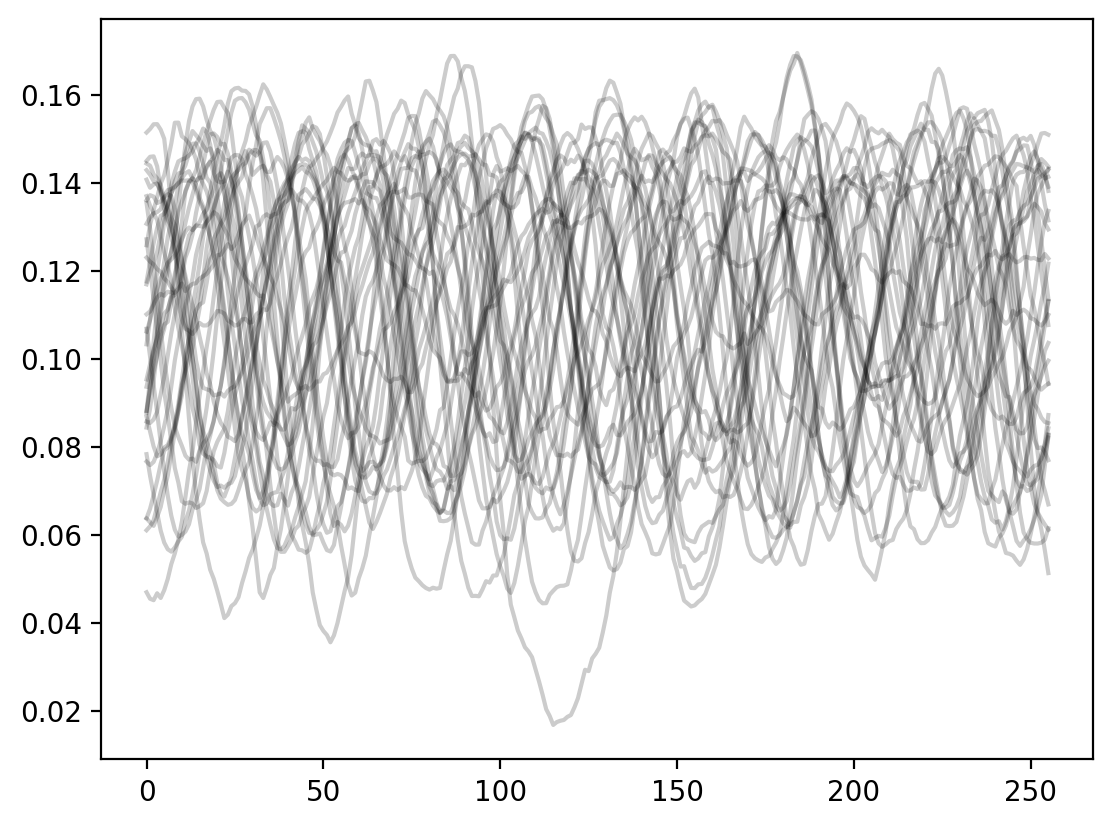

In [14]:
xw = xs[-8192:,0,12].reshape((-1, 256))
plot(xw.T, 'k', alpha=0.2);

In [15]:
xw.shape

(32, 256)

In [16]:
Xw = np.fft.fft(xw, axis=-1)

In [17]:
freqs = np.fft.fftfreq(xw.shape[1], d=2e-3)

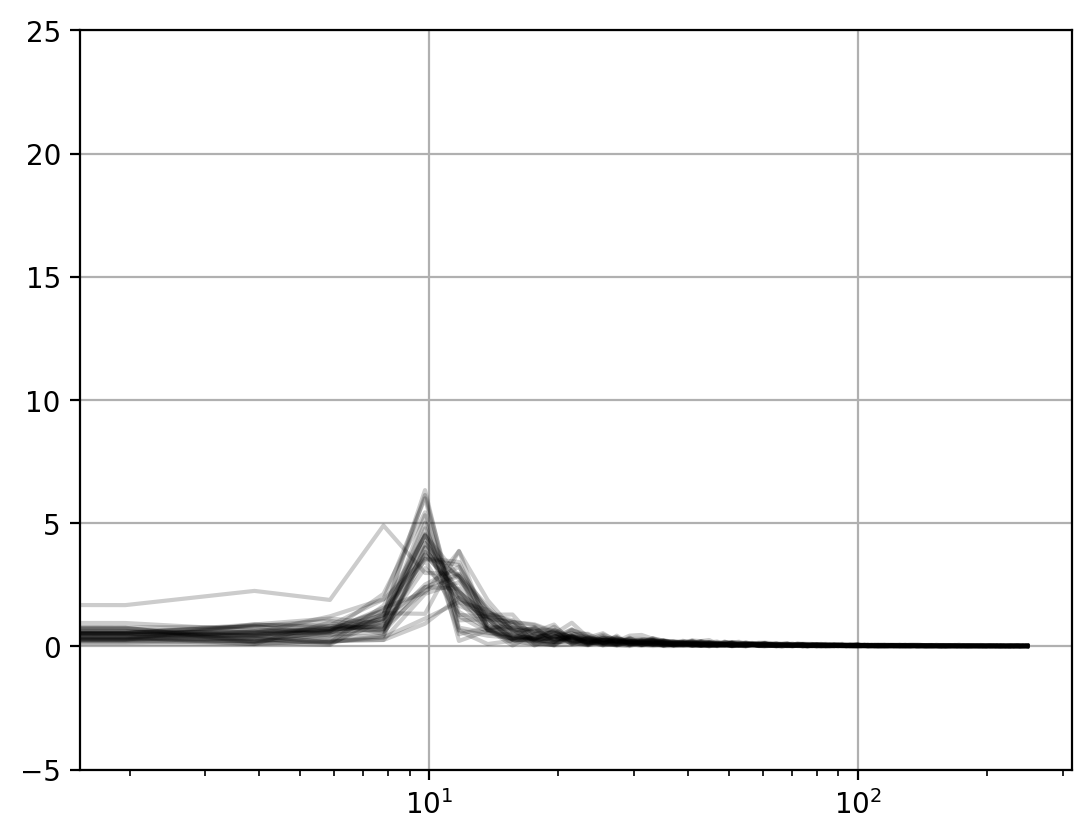

In [18]:
semilogx(freqs[freqs>=0], np.abs(Xw).T[freqs>=0], 'k', alpha=0.2); ylim([-5,25]); grid(1)

### Cross-spectral density

In [19]:
xw = xs[-8192:,0,::12].reshape((32, 256, -1))
xw.shape

(32, 256, 7)

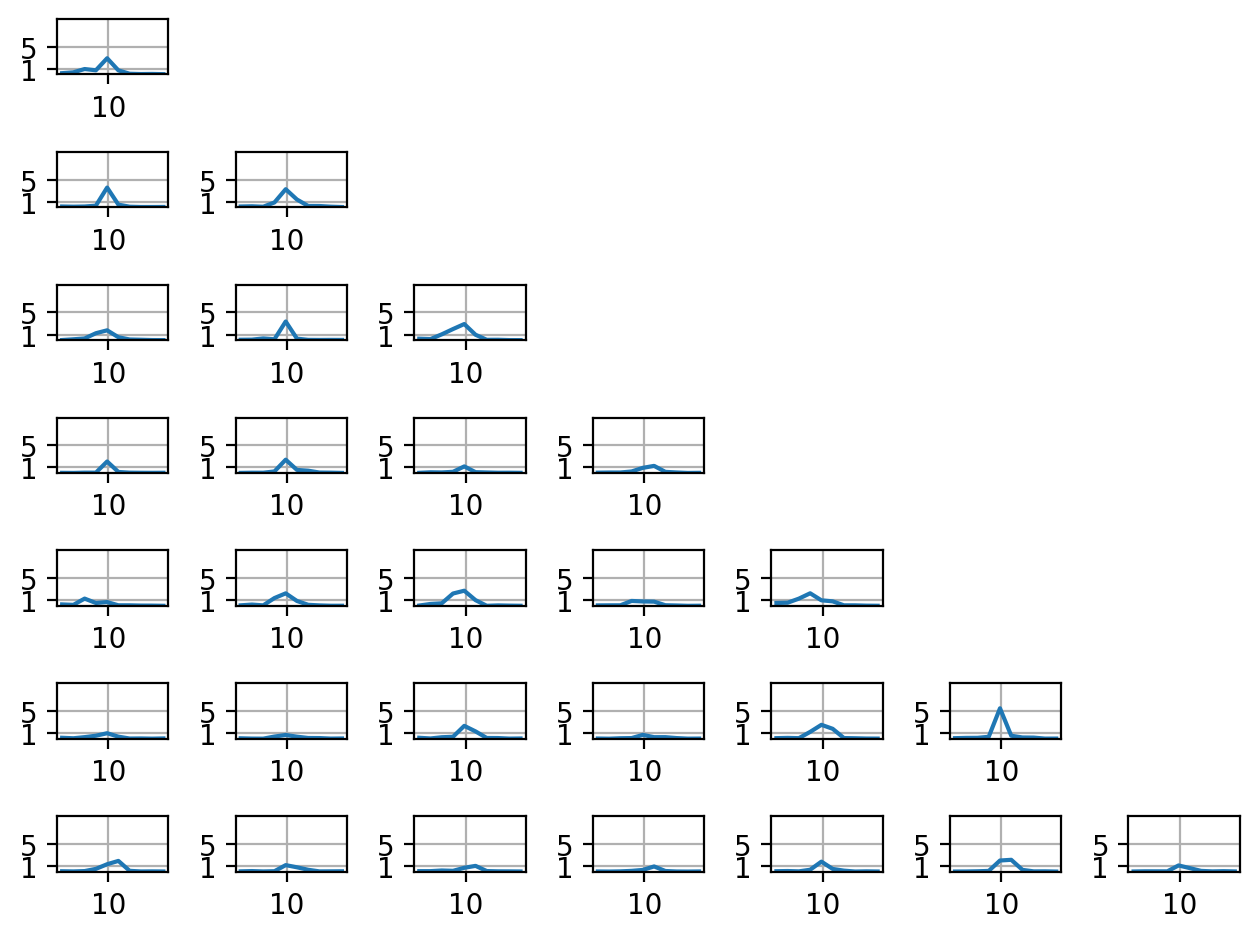

In [20]:
i, j = 1, 2



fm = (freqs>0) * (freqs<20)

for i in range(7):
    for j in range(7):
        if i<j:
            continue
        subplot(7, 7, 7*i+j+1)
        Xi = np.fft.fft(xw[..., i], axis=-1)
        Xj = np.fft.fft(xw[..., j], axis=-1)
        Cij = Xi * Xj
        plot(freqs[fm], np.abs(np.mean(Cij, axis=0)).T[fm])
        yticks([1,5]); ylim([0,10]); xticks([10]); grid(1)
tight_layout()

In [21]:
np.abs(np.mean(Cij, axis=0)).T[fm].shape

(10,)

In [22]:
(7*7 - 7) // 2

21

This arbitrarily reduces the spatial sampling to 7 electrodes, but results in 210 element cross-spectral density (CSD) vector per simulation.

We can rewrite the steps above into a single vectorized function,

In [23]:
def make_compute_csd():
    nfft = 256
    freqs = np.fft.fftfreq(nfft, d=dt*1e-3)    # spectral frequency
    fm = (freqs>0) * (freqs<20)                       # mask
    def compute_csd(xs):
        xw = xs[-8192:,0,::12].reshape((32, nfft, 7))     # make windows of 256
        Xw = np.fft.fft(xw, axis=1)                       # compute spectrum
        cX = Xw[...,None] * Xw[...,None,:]                # cross spectra
        i, j = np.tril_indices(xw.shape[-1],-1)           # tri off diag indices
        return np.abs(np.mean(cX, axis=0))[fm][:,i,j]     # average windows, abs val
    return compute_csd

compute_csd = make_compute_csd()

%timeit compute_csd(xs)

3.16 ms ± 149 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


This isn't ideal but since we'll batch it later, it doesn't matter much.

## Data feature validation

- [ ] identical parameters but different noise realizations give consistent CSD vectors
- [ ] different parameters yield different CSD vectors
- [ ] different connectomes yield different CSD vectors

### Robustness to noise

In [24]:
def run_many_rand(n_sim=100):
    key = jax.random.PRNGKey(42)
    cx = []
    for k in tqdm.tqdm(jax.random.split(key, n_sim)):
        zs = jax.random.normal(key=k, shape=(10000, 6, nn))
        xs = loop(x, zs, k_p)
        cx.append(compute_csd(xs))
    return np.array(cx)

(cx := run_many_rand()).shape

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.03it/s]


(100, 10, 21)

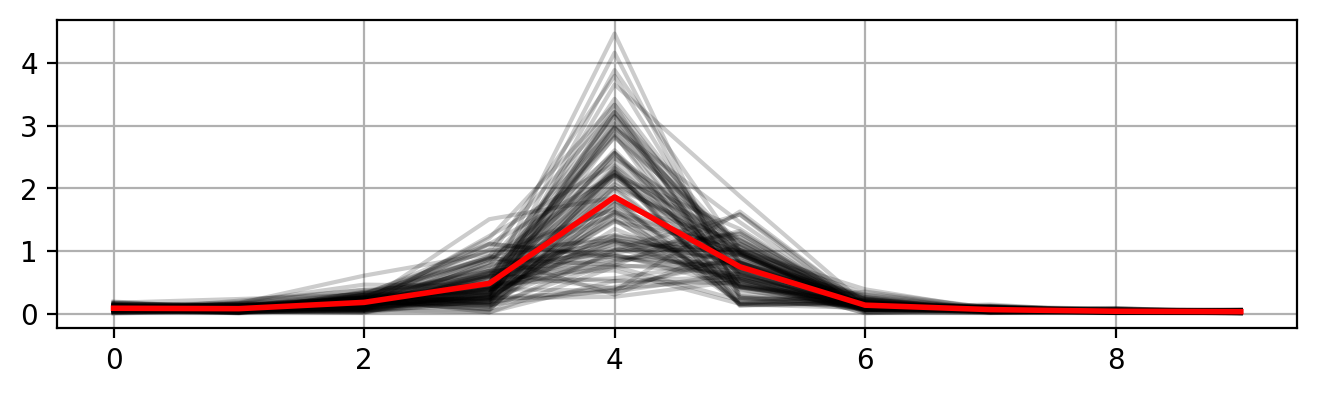

In [25]:
figure(figsize=(8,2))
i = 12
plot(cx[:,:,i].T, 'k', alpha=0.2);
plot(cx[:,:,i].mean(axis=0), 'r', linewidth=2)
grid(1);

Is that consistent enough? 

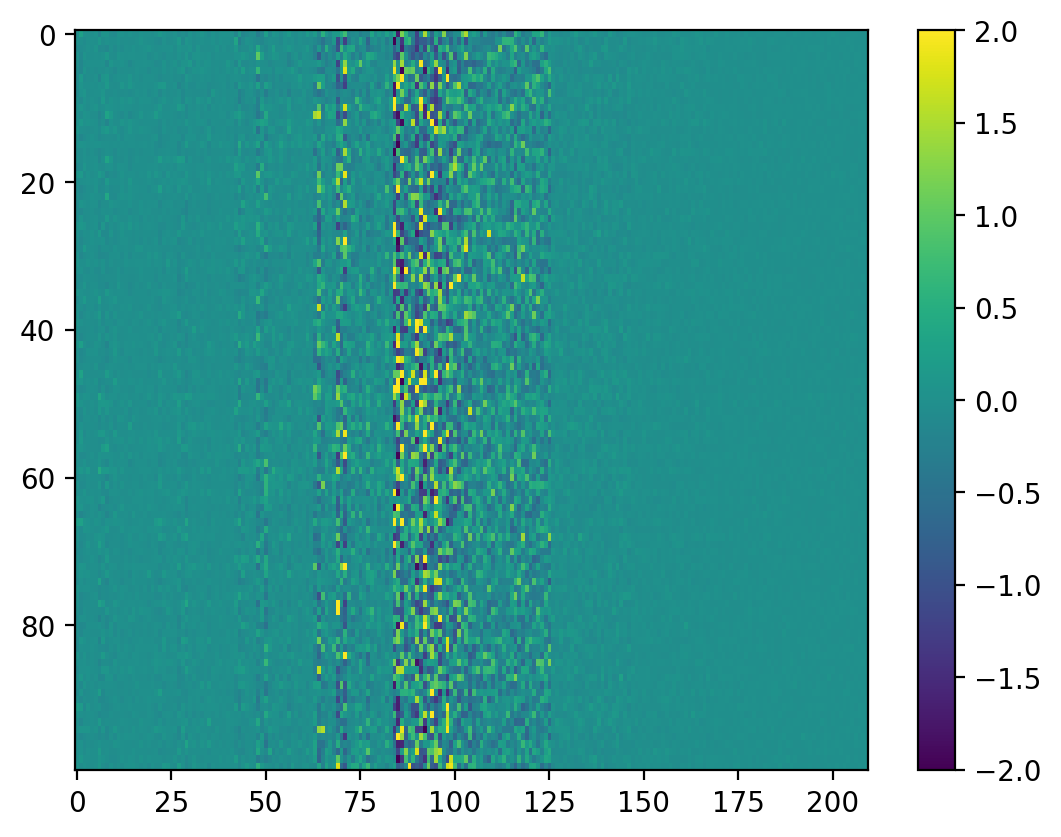

In [26]:
cx_mu = cx.mean(axis=0).reshape(-1)
imshow(cx.reshape((-1, 210)) - cx_mu, interpolation='none', aspect='auto', vmin=-2, vmax=2); colorbar()

So it seems that only some of the feature elements are relevant, but that's fine.

### Sensitivity to parameters

In [27]:
k_values = 10**np.r_[-4.0:-2.5:64j]

In [28]:
cx = []
for i, k in enumerate(k_values):
    k_p = k, p
    zs = jax.random.normal(key=jax.random.PRNGKey(42+i),
                           shape=(10000, 6, nn))
    xs = loop(x, zs, k_p)
    cx.append(compute_csd(xs))
cx = np.array(cx)

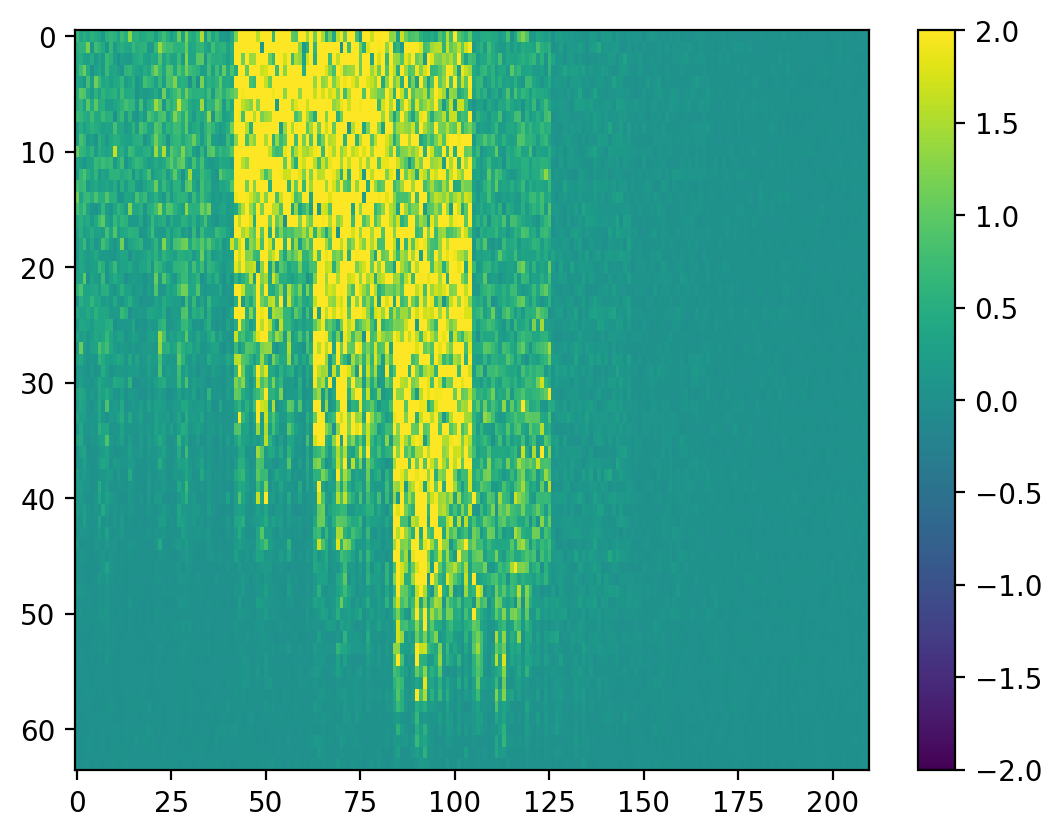

In [29]:
imshow(cx.reshape((-1, 210)), interpolation='none', aspect='auto', vmin=-2, vmax=2); colorbar()

Here we see that the increase in coupling strength induces a change in the resulting feature vector.

### Sensitivity to connectome

The feature should be sensitive to connectomes

In [30]:
SCs = np.array(weights)
SCs = SCs + SCs.transpose((0,2,1))
SCs /= SCs.reshape((100,-1)).max(axis=-1)[:,None,None]
SCs = np.sqrt(SCs)  # Spase Qetkoski's Rational Trick

In [31]:
def net_dfun(x, k_SC_p):
    k, SC, p = k_SC_p
    return vbjax.jr_dfun(x, k*SC@(x[1] - x[0]), p)
dt = 2.0
step, loop = vbjax.make_sde(dt, net_dfun, 0.0005)
zs = jax.random.normal(key=key, shape=(500+8192, 6, nn))
cx = []
for sc in SCs:
    k_SC_p = 1e-3, sc, p
    xs = loop(x, zs, k_SC_p)
    cx.append(compute_csd(xs))
cx = np.array(cx)

Do the resulting the cross spectra confuse connectomes? We can look at the similarity and check for a diagonal:

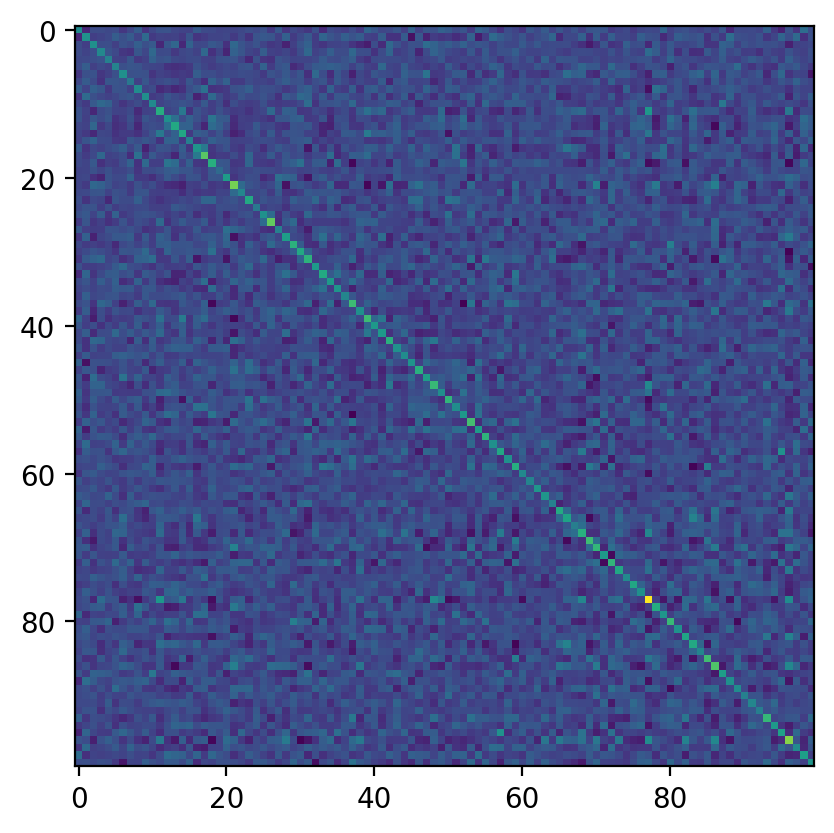

In [32]:
cx_ = cx.reshape((100, -1))
cx_d = cx_ - cx_.mean(axis=0)
imshow(cx_d @ cx_d.T)

This suggests that the cross spectra is sufficient to help identify the connectome.

## Run lots of simulations

Now we'll test this out by running a lot of simulations

### Basic for loop

In the basic case, we need a set of connectomes, parameter values & random keys.

In [50]:
u_mean, u_cov, u_to_sc = vbjax.make_conn_latent_mvnorm(SCs)

def make_inputs(key, n_sim):
    # Random keys
    keys = jax.random.split(key, 2 + n_sim)
    sc_key, par_key, noise_key = keys[0], keys[1], keys[2:]
    samp_u = jax.random.multivariate_normal(sc_key, u_mean, u_cov, shape=(n_sim,))
    samp_k = 10**jax.random.uniform(par_key, (n_sim,), minval=-4.0, maxval=-2.5)
    # zs is too big to build at all once?
    return samp_u, samp_k, noise_key

In [51]:
key = jax.random.PRNGKey(42)
samp_u, samp_k, noise_key = make_inputs(key, 100)

cx = []
for u, k, nk in tqdm.tqdm(zip(samp_u, samp_k, noise_key)):
    k_SC_p = 1e-3, u_to_sc(u), p
    zs = jax.random.normal(key=nk, shape=(10000, 6, nn))
    xs = loop(x, zs, k_SC_p)
    cx.append(compute_csd(xs))
cx = np.array(cx)

100it [00:03, 32.80it/s]


### Parallelize on CPU

If we set the XLA flags thingy (see top of notebook) then we can use `jax.pmap` as described in the [the docs](https://jax.readthedocs.io/en/latest/jax-101/06-parallelism.html):

In [52]:
import time

@jax.jit
def run_one(u, k, nk):
    k_SC_p = 1e-3, u_to_sc(u), p
    zs = jax.random.normal(key=nk, shape=(10000, 6, nn))
    xs = loop(x, zs, k_SC_p)
    return compute_csd(xs)

pmap_run = jax.pmap(run_one)

nloops = 1000
keys = jax.random.split(jax.random.PRNGKey(42), nloops)
samp_us, samp_ks = [], []
cx = []
for i in tqdm.trange(nloops):
    samp_u, samp_k, noise_key = make_inputs(keys[i], 8)
    samp_us.append(samp_u)
    samp_ks.append(samp_k)
    cx.append(pmap_run(samp_u, samp_k, noise_key))
cx = np.array(cx)
cx.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:05<00:00, 15.36it/s]


(1000, 8, 10, 21)

So now 

### Thread batch on GPU

*Can worry about this when on a machine with a GPU*

## Neural network for parameter mapping

Let's start by getting our simulations into shape

In [220]:
u = np.array(samp_us).reshape((8000, -1))
k = np.array(samp_ks).reshape((8000,))
cx = cx.reshape((8000, -1))
theta = np.c_[u, np.log(k)]
cx.shape, theta.shape

((8000, 210), (8000, 11))

where `cx` is our observation and `theta` are the parameters that yielded the observation.

In the case of SBI, we want to map `cx` to variational parameters of a distribution over `theta`.  Let's first start with a simpler problem of mapping `cx` to `theta` without the distribution.

In [221]:
from jax.example_libraries.optimizers import adam

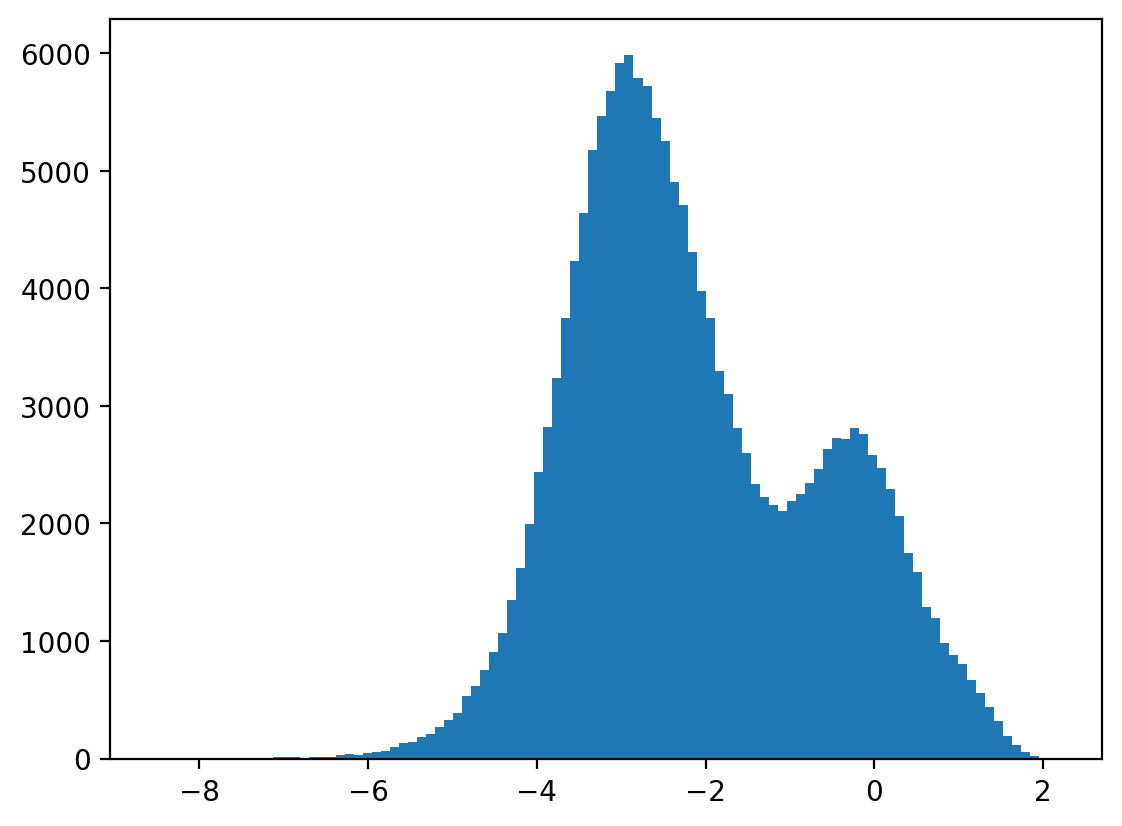

In [222]:
hist(np.log(cx.reshape(-1)[::10]), 100);

In [223]:
lcx = np.log(cx)

0 44.46303
1000 4.31623
2000 2.2295294
3000 1.0026691
4000 0.43552807
5000 0.3197599
6000 0.3142775
7000 0.31316698
8000 0.3120095
9000 0.31168514
10000 0.31276375


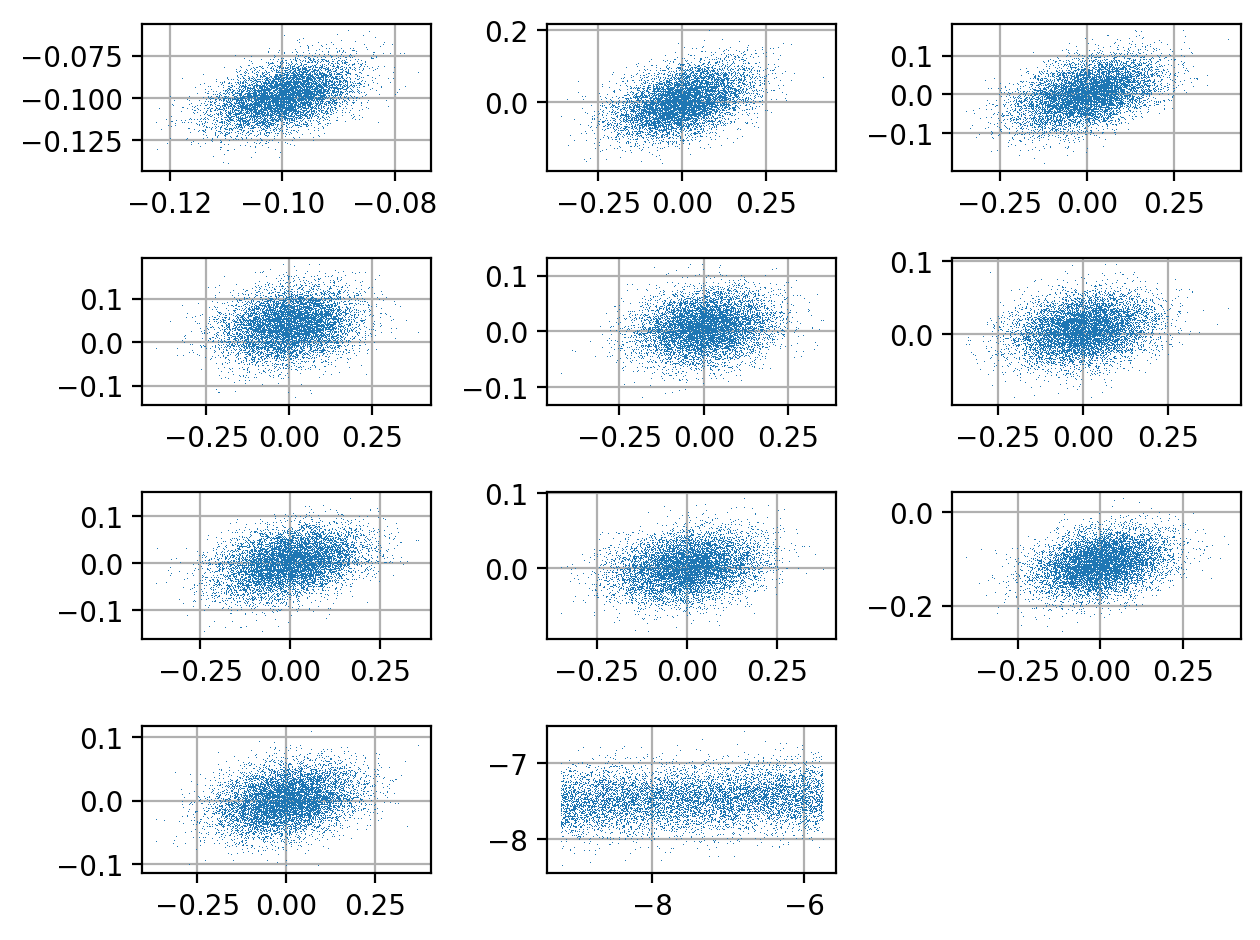

In [229]:
small = lambda shape: jax.random.normal(key, shape=shape)
a = [small((210, theta.shape[1]))]
b = [small((theta.shape[1],))]

layer = lambda a, b, x: jax.nn.leaky_relu(x @ a + b)

def pred(p, z):
    a, b = p
    # z = layer(a[0], b[0], z)
    # z = layer(a[1], b[1], z)
    theta_h = z @ a[0] + b[0]
    return theta_h
    
def loss(p):
    theta_h = pred(p, lcx)
    sse = np.sum(np.square(theta - theta_h))
    return sse

grad_loss = jax.jit(jax.grad(loss))

opt = adam(0.01)
opt_x = opt.init_fn((a, b))

for i in range(10001):
    p = opt.params_fn(opt_x)
    g = grad_loss(p)
    if i%1000 == 0:
        print(i, np.sqrt(loss(p)/theta.size))
    opt_x = opt.update_fn(i, g, opt_x)

p = opt.params_fn(opt_x)
theta_h = pred(p, lcx)

for i in range(11):
    subplot(4,3, i+1)
    plot(theta[:, i],theta_h[:, i], ',')
    grid(1)
tight_layout()

The results are not as precise as we'd like, we could include more "sensors" in the data to improve the result.

### Again but with better resolution

In [234]:
def make_compute_csd():
    nfft = 512
    freqs = np.fft.fftfreq(nfft, d=dt*1e-3)    # spectral frequency
    fm = (freqs>0) * (freqs<20)                       # mask
    nwin = 8192 // nfft
    def compute_csd(xs):
        xw = xs[-8192:,0,::5].reshape((nwin, nfft, -1))     # make windows of 256
        Xw = np.fft.fft(xw, axis=1)                       # compute spectrum
        cX = Xw[...,None] * Xw[...,None,:]                # cross spectra
        i, j = np.tril_indices(xw.shape[-1],-1)           # tri off diag indices
        return np.abs(np.mean(cX, axis=0))[fm][:,i,j]     # average windows, abs val
    return compute_csd

compute_csd = make_compute_csd()
compute_csd(xs).size

2720

In [241]:
@jax.jit
def run_one(u, k, nk):
    k_SC_p = 1e-3, u_to_sc(u), vbjax.jr_default_theta
    zs = jax.random.normal(key=nk, shape=(10000, 6, nn))
    xs = loop(x, zs, k_SC_p)
    return compute_csd(xs)

In [243]:
run_one(samp_u[0], samp_k[0], noise_key[0]).shape

(20, 136)

In [382]:
run_one_p = jax.pmap(run_one)

nloops = 8000
keys = jax.random.split(jax.random.PRNGKey(42), nloops)
samp_us, samp_ks = [], []
cx = []
for i in tqdm.trange(nloops):
    samp_u, samp_k, noise_key = make_inputs(keys[i], 8)
    samp_us.append(samp_u)
    samp_ks.append(samp_k)
    cx.append(run_one_p(samp_u, samp_k, noise_key))
cx = np.array(cx)

In [383]:
u = np.array(samp_us).reshape((nloops*8, -1))
k = np.array(samp_ks).reshape((nloops*8,))
cx = cx.reshape((nloops*8, -1))
theta = np.c_[u, np.log(k)]
cx.shape, theta.shape

((64000, 2720), (64000, 11))

In [384]:
lcx = np.log(cx)

small = lambda shape: jax.random.normal(key, shape=shape)
a = [small((cx.shape[1], theta.shape[1]))]
b = [small((theta.shape[1],))]

layer = lambda a, b, x: jax.nn.leaky_relu(x @ a + b)

def pred(p, z):
    a, b = p
    # z = layer(a[0], b[0], z)
    # z = layer(a[1], b[1], z)
    theta_h = z @ a[0] + b[0]
    return theta_h
    
def loss(p):
    theta_h = pred(p, lcx)
    sse = np.sum(np.square(theta - theta_h))
    return sse

grad_loss = jax.jit(jax.grad(loss))

opt = adam(0.01)
opt_x = opt.init_fn((a, b))

0 121.72027
1000 19.971199
2000 11.175475
3000 7.0213375
4000 3.2335672
5000 1.2253631
6000 0.8154022
7000 3.4829075
8000 2.2607257
9000 0.388706
10000 1.8880522


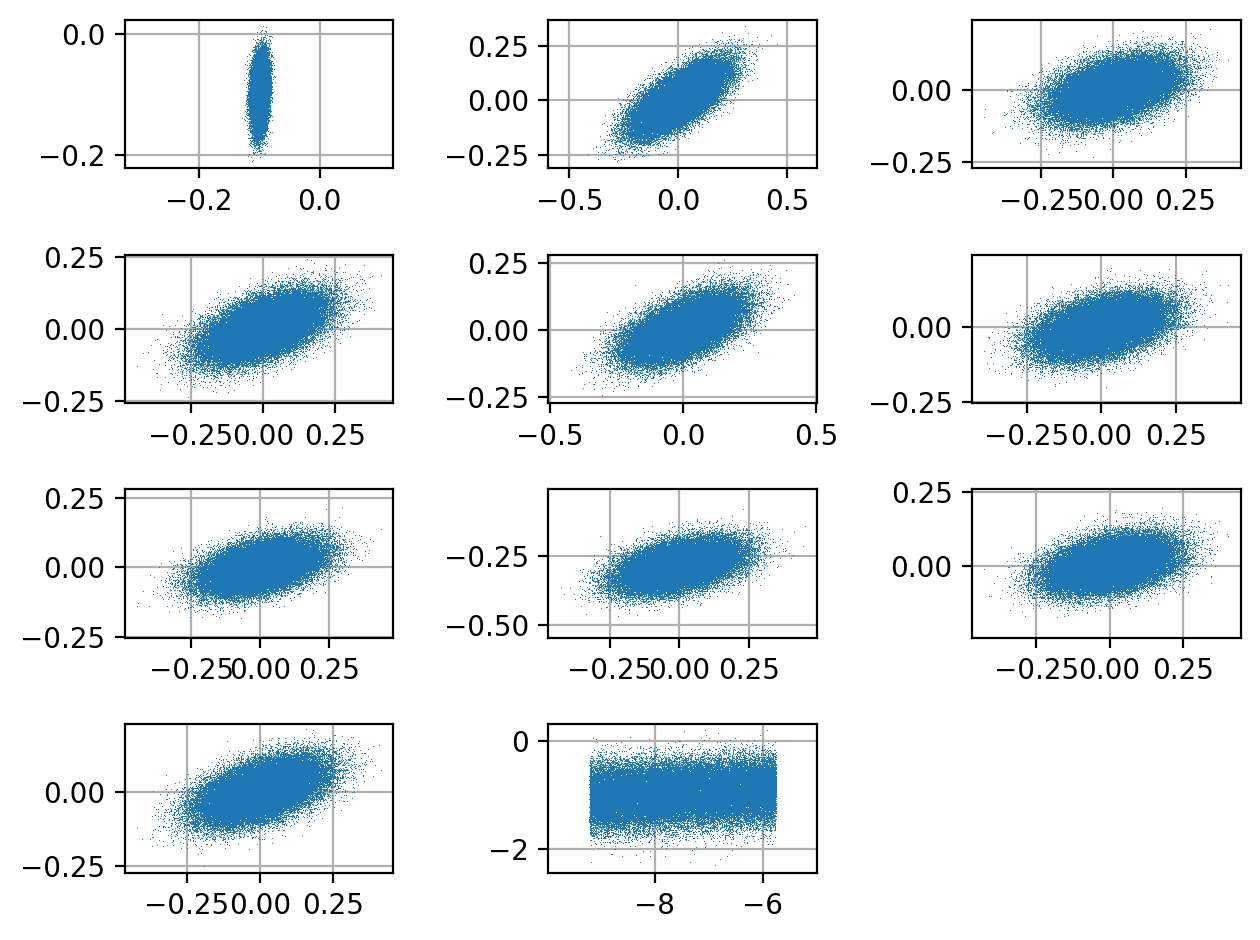

In [385]:
for i in range(10001):
    p = opt.params_fn(opt_x)
    g = grad_loss(p)
    if i%1000 == 0:
        print(i, np.sqrt(loss(p)/theta.size))
    opt_x = opt.update_fn(i, g, opt_x)

p = opt.params_fn(opt_x)
theta_h = pred(p, lcx)

for i in range(11):
    subplot(4,3, i+1)
    plot(theta[:, i],theta_h[:, i], ',')
    axis('equal'); grid(1)
tight_layout()

That's much closer to what we want.  Now, let's try it probabilistically.

### Probably: diagonal MvNorm

Instead of predicting `theta` from `cx`, we could also try to maximize some `p(theta | cx) ~ N(f(gx), g(cx))` where `f` and `g` are outputs of a neural network.

We can start with a diagonal covariance approach,

In [390]:
%pdb on

Automatic pdb calling has been turned ON


In [401]:
key = jax.random.PRNGKey(120)
small = lambda shape: jax.random.normal(key, shape=shape)*1e-3
a = small((2, cx.shape[1], theta.shape[1]))
b = small((2, theta.shape[1],))

def pred(p, z):
    a, b = p
    theta_mu = z @ a[0] + b[0]
    theta_sd_star = z @ a[1] + b[1]
    return theta_mu, theta_sd_star
    
def loss(p):
    theta_mu, theta_sd_star = pred(p, lcx)
    lp = np.sum(jax.scipy.stats.norm.logpdf(theta, theta_mu, np.exp(theta_sd_star)))
    lp = lp + np.sum(jax.scipy.stats.norm.logpdf(theta_sd_star, -2, 0.1))
    return -lp

grad_loss = jax.grad(loss)

p = a, b
loss(p)

Array(1.4509707e+08, dtype=float32)

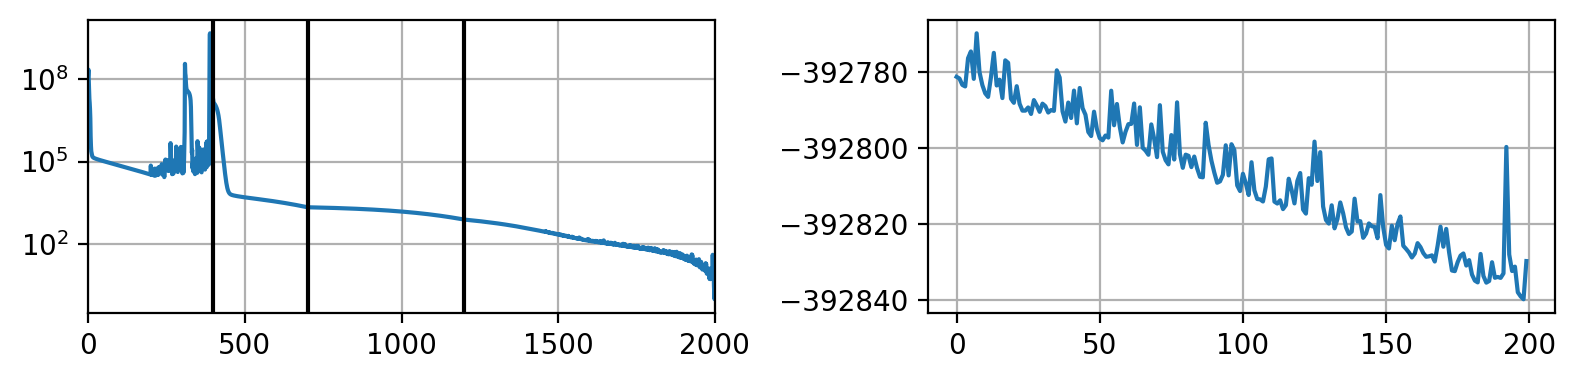

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20001/20001 [3:10:43<00:00,  1.75it/s]


In [403]:
opt = adam(0.0005)
opt_x = opt.init_fn((a, b))

n_last_loss = 20
losses = []
for i in tqdm.trange(20001):
    p = opt.params_fn(opt_x)
    g = grad_loss(p)
    if i%10 == 0:
        clear_output(wait=True)
        _, sds = pred(p,lcx)
        loss_i = loss(p)
        losses.append(loss_i)
        figure(figsize=(8,2))
        subplot(121);
        losses_ = np.array(losses)
        semilogy(losses_ - losses_.min() + 1)
        xlim([0,2000]), grid(1), axvline(400,color='k'), axvline(700,color='k'), axvline(1200,color='k')
        subplot(122); plot(losses[-n_last_loss:]);grid(1) # TODO show more points for smaller learning step sizes
        tight_layout(); show()
    opt_x = opt.update_fn(i, g, opt_x)
    if i > 4000:
        opt = adam(0.00005)
        n_last_loss = 200
    if i > 7000:
        opt = adam(0.000005)
    if i > 12000:
        opt = adam(0.0000025)

We could consider a minibatch variant.

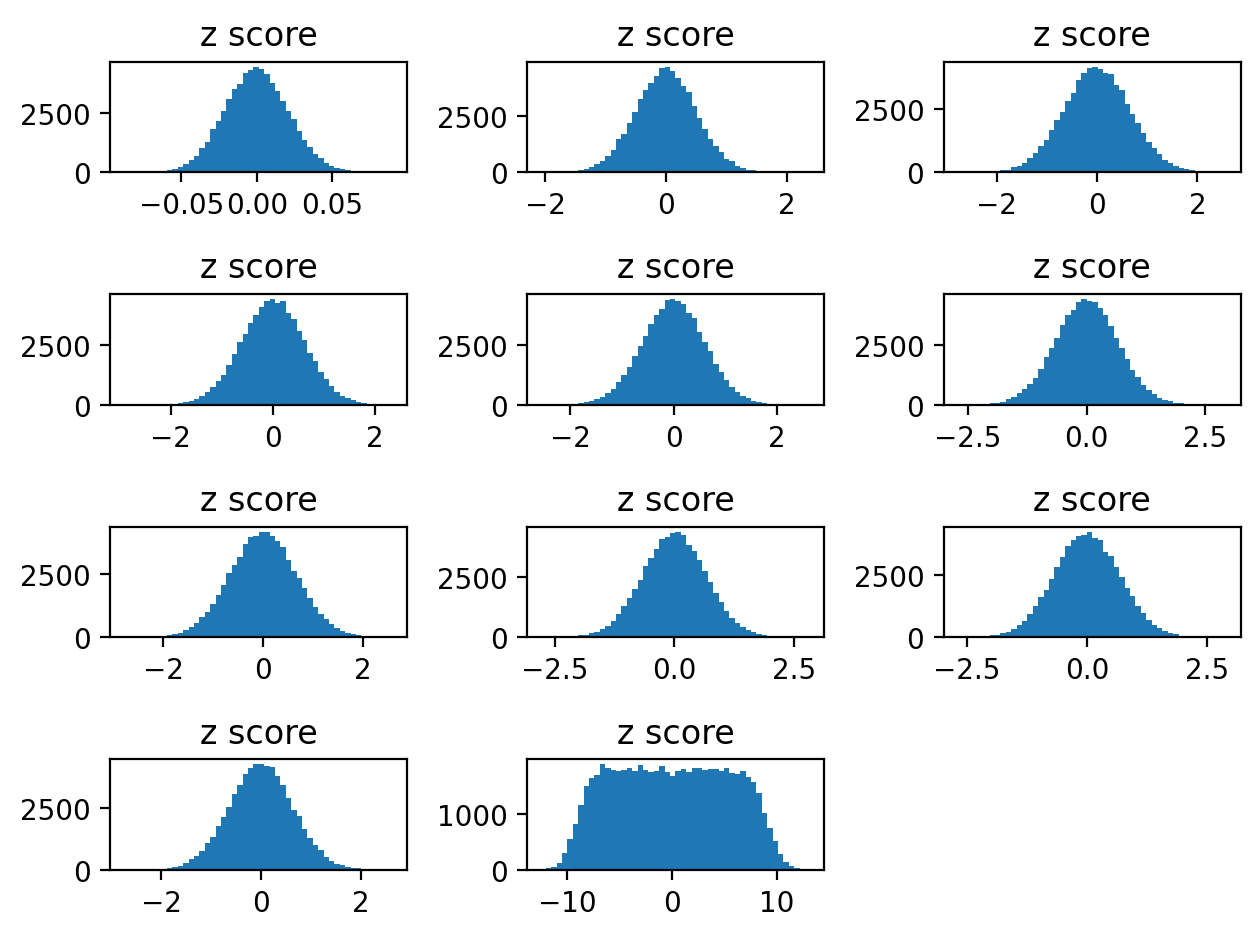

In [404]:
p = opt.params_fn(opt_x)
theta_mu, theta_sd_star = pred(p, lcx)
theta_sd = np.exp(theta_sd_star)

for i in range(11):
    subplot(4,3, i+1)
    hist((theta[:, i] - theta_mu[:, i])/theta_sd[:, i], 50)
    title('z score')
tight_layout()

That's looking ok: once the true values are z-scored, they all (except last one) fall less than 1 sigma deviation.  So we can pick one of the simulations and plot the posterior:

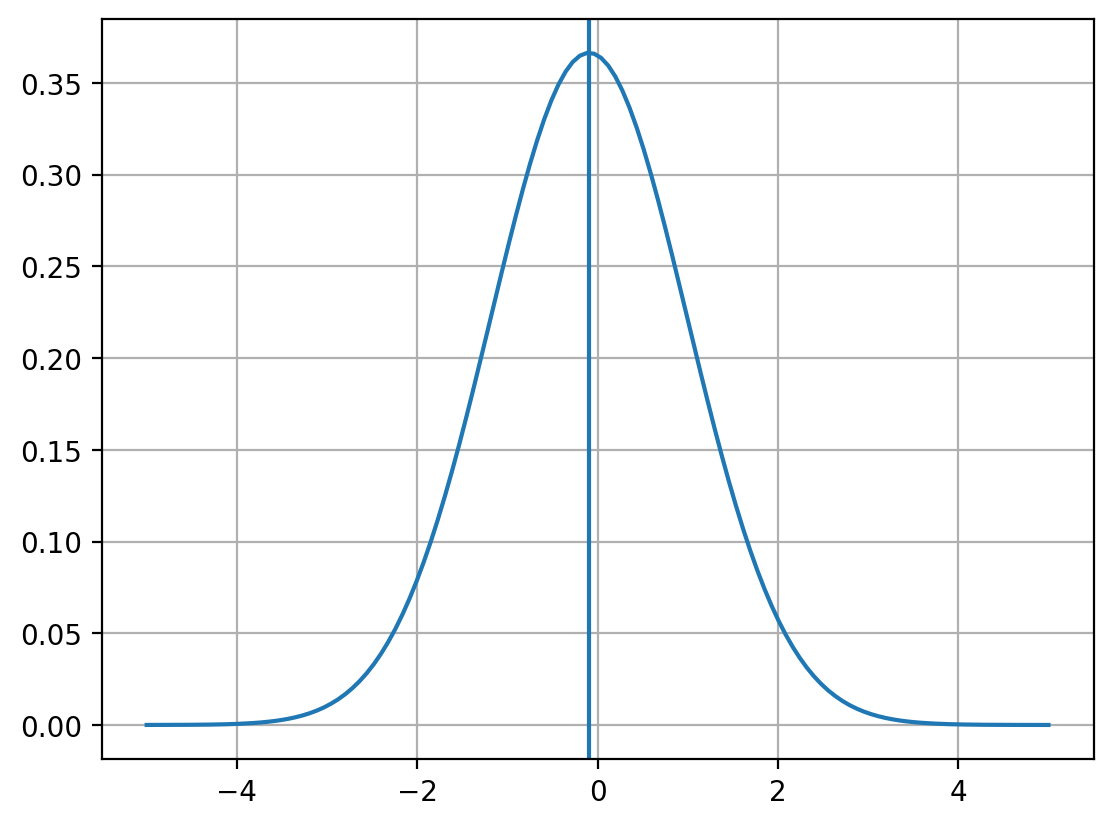

In [397]:
i = 2300
j = 0
lcx_i = np.log(cx[i])
mu,sd = pred(p,lcx_i)
N = lambda *args: np.exp(jax.scipy.stats.norm.logpdf(*args))
t = np.r_[-5:5:128j]
plot(t, N(t, mu[j], sd[j]))
axvline(theta[i,j])
grid(1)

The distribution is too wide ot be of practical use.

In [ ]:










# this page intentionally left blank







